# Student Feedback Sentiment Classification

**Module:** CC6057NI - Applied Machine Learning

**Student Name:** Prajol Bimali

**London Met ID:** 23048651

**College ID:** np01ai4a230099

## Project Overview
This notebook contains the complete implementation of a Text Classification System designed to automate the analysis of student course feedback.

## **Loading Dataset**

In [31]:
import pandas as pd

df = pd.read_csv('feedback_student.csv')

df.head()

,Id,comment,quality
0,45881,"Rand was a good guy, really... he was. But I f...",awful
1,45881,"He is brilliant in his field, but expects his ...",poor
2,45881,He has a major in philosophy which is why all ...,awful
3,45881,I thought his class was extremely hard but des...,good
4,45881,I recently just finished taking Comp 110 with ...,poor


In [32]:
len(df)

2345

# Data Analysis: Raw Label Distribution

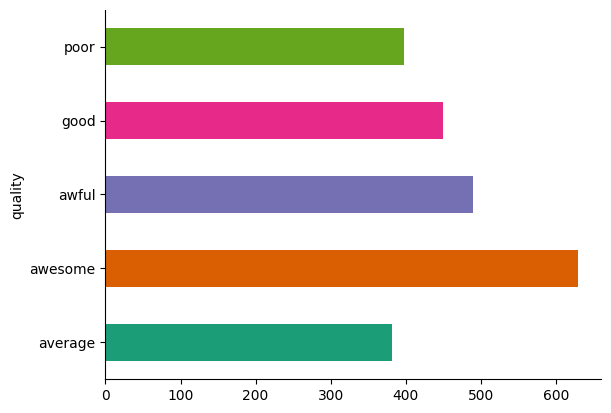

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('quality').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Renaming columns

In [34]:
#Rename columns for clarity
df = df.rename(columns={
    'comment': 'student_feedback',
    'quality': 'original_label'
})

# Map Labels
label_converter = {
    'awesome': 'Positive', 'good': 'Positive',
    'average': 'Neutral',
    'poor': 'Negative', 'awful': 'Negative'
}
df['sentiment'] = df['original_label'].map(label_converter)

## NLP Library setup

In [35]:
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Lemmatizer and Stop Words
lemmatizer = WordNetLemmatizer()
english_stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Text preprocessing and cleaning pipeline

In [36]:

# Cleaning Function
def clean_text_function(raw_text):
    text = str(raw_text).lower()
    # Remove special characters/numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    # Lemmatize and remove stop words
    cleaned = [lemmatizer.lemmatize(w) for w in words if w not in english_stop_words]
    return ' '.join(cleaned)

df['processed_feedback'] = df['student_feedback'].apply(clean_text_function)

# Show preview
display(df.head())

,Id,student_feedback,original_label,sentiment,processed_feedback
0,45881,"Rand was a good guy, really... he was. But I f...",awful,Negative,rand good guy really felt alterego left go hom...
1,45881,"He is brilliant in his field, but expects his ...",poor,Negative,brilliant field expects student perform high l...
2,45881,He has a major in philosophy which is why all ...,awful,Negative,major philosophy paper write based philosophy ...
3,45881,I thought his class was extremely hard but des...,good,Positive,thought class extremely hard despite became co...
4,45881,I recently just finished taking Comp 110 with ...,poor,Negative,recently finished taking comp rand hardest cla...


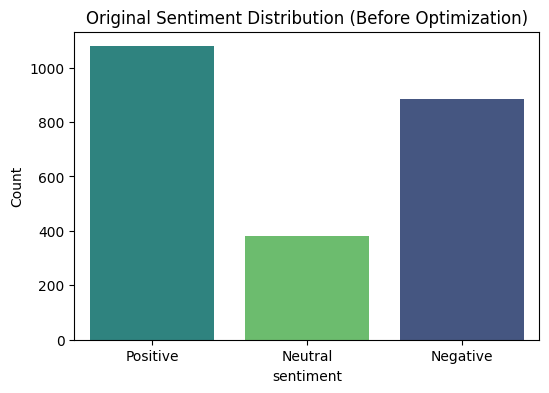

sentiment
Positive    1078
Negative     886
Neutral      381
Name: count, dtype: int64


In [37]:
plt.figure(figsize=(6, 4))
sns.countplot(
    x='sentiment',
    data=df,
    order=['Positive', 'Neutral', 'Negative'],
    hue='sentiment', palette='viridis', legend=False
)
plt.title('Original Sentiment Distribution (Before Optimization)')
plt.ylabel('Count')
plt.show()

print(df['sentiment'].value_counts())

### **TF-IDF Vectorization**

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Removing 'Neutral' class to reduce ambiguity

# copy of data excluding Neutral
binary_data = df[df['sentiment'] != 'Neutral'].copy()

# initialize vectorizer (Unigrams + Bigrams)
tfidf_binary = TfidfVectorizer(max_features=5000, ngram_range=(1,2)) #why 5000 first may be look at the dataset and true scale of that then only decide on number

#tfidf = TfidfVectorizer(max_features=5000)
#X = tfidf.fit_transform(df['processed_feedback']).toarray()
#y = df['sentiment']

# Features (X) and Labels (y)
X_binary = tfidf_binary.fit_transform(binary_data['processed_feedback']).toarray()
y_binary = binary_data['sentiment']

## **Train Test split**

In [39]:
# Split Data
# 'stratify=y_binary' ensures the Train/Test sets have the same ratio of Positive/Negative
# as the original data, preventing the model from missing the minority class.
X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Binary Dataset Size: {len(binary_data)}")
print(f"Training Shape: {X_train.shape} | Testing Shape: {X_test.shape}")

Binary Dataset Size: 1964
Training Shape: (1571, 5000) | Testing Shape: (393, 5000)


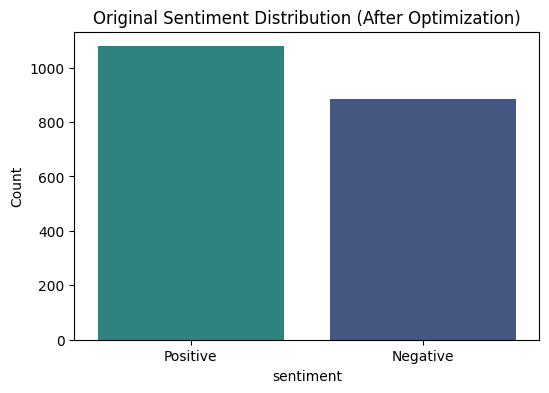

In [40]:
plt.figure(figsize=(6, 4))
sns.countplot(
    x='sentiment',
    data=df,
    order=['Positive', 'Negative'],
    hue='sentiment', palette='viridis', legend=False
)
plt.title('Original Sentiment Distribution (After Optimization)')
plt.ylabel('Count')
plt.show()

In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix

def evaluate_model_performance(model, model_name, X_tr, y_tr, X_te, y_te):
    print(f"\n{model_name}")

    # Cross Validation
    # Used 'f1_weighted' to handle string labels 'Positive'/'Negative' directly
    # and to account for class imbalance.
    cv_scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='f1_weighted')
    print(f"Cross-Validation F1 Scores: {cv_scores}")
    print(f"Mean CV Score: {cv_scores.mean():.4f}")

    # Train on full training set
    model.fit(X_tr, y_tr)

    # Predict on Test set
    preds = model.predict(X_te)

    # Calculate Metrics
    acc = accuracy_score(y_te, preds)
    f1 = f1_score(y_te, preds, pos_label='Positive', average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("-" * 30)
    print(classification_report(y_te, preds))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_te, preds, labels=['Positive', 'Negative'])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Positive', 'Negative'],
                yticklabels=['Positive', 'Negative'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return acc, f1

## **Training Model and Evaluation of Model Accuracy With Confusion matrix**


Random Forest
Cross-Validation F1 Scores: [0.81898865 0.83752465 0.8597807  0.82692951 0.80598035]
Mean CV Score: 0.8298
Test Accuracy: 0.8219
Test F1 Score: 0.8222
------------------------------
              precision    recall  f1-score   support

    Negative       0.79      0.82      0.81       177
    Positive       0.85      0.82      0.83       216

    accuracy                           0.82       393
   macro avg       0.82      0.82      0.82       393
weighted avg       0.82      0.82      0.82       393



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'Positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


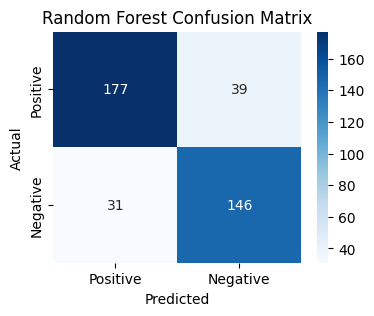


KNN
Cross-Validation F1 Scores: [0.75710696 0.78001025 0.81814509 0.81980016 0.76417113]
Mean CV Score: 0.7878


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'Positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


Test Accuracy: 0.7990
Test F1 Score: 0.7975
------------------------------
              precision    recall  f1-score   support

    Negative       0.81      0.72      0.76       177
    Positive       0.79      0.86      0.82       216

    accuracy                           0.80       393
   macro avg       0.80      0.79      0.79       393
weighted avg       0.80      0.80      0.80       393



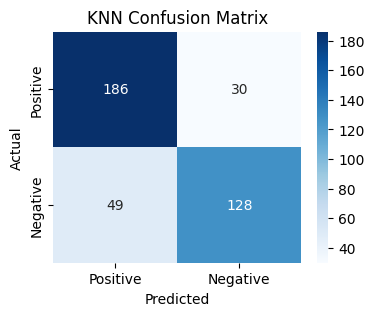


Support Vector Machine
Cross-Validation F1 Scores: [0.82196825 0.85681544 0.86970455 0.82072779 0.83752805]
Mean CV Score: 0.8413
Test Accuracy: 0.8219
Test F1 Score: 0.8222
------------------------------
              precision    recall  f1-score   support

    Negative       0.79      0.83      0.81       177
    Positive       0.85      0.81      0.83       216

    accuracy                           0.82       393
   macro avg       0.82      0.82      0.82       393
weighted avg       0.82      0.82      0.82       393



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1618: UserWarning: Note that pos_label (set to 'Positive') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


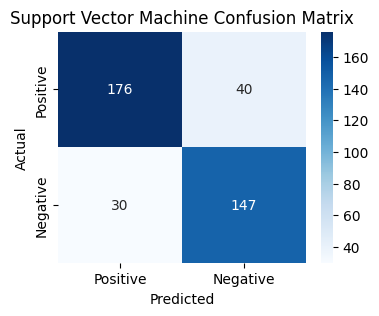

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# TRaining

#Random Forest
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42) # one positive class 1000, negative 100,
rf_acc, rf_f1 = evaluate_model_performance(rf_model, "Random Forest", X_train, y_train, X_test, y_test)

#KNN (Cosine Distance)
#knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model = KNeighborsClassifier(n_neighbors=9, metric='cosine')
knn_acc, knn_f1 = evaluate_model_performance(knn_model, "KNN", X_train, y_train, X_test, y_test)

#Linear SVM
svm_model = LinearSVC(C=1.0, class_weight='balanced', dual='auto', random_state=42)
svm_acc, svm_f1 = evaluate_model_performance(svm_model, "Support Vector Machine", X_train, y_train, X_test, y_test)

## **ROC Curve visualization**

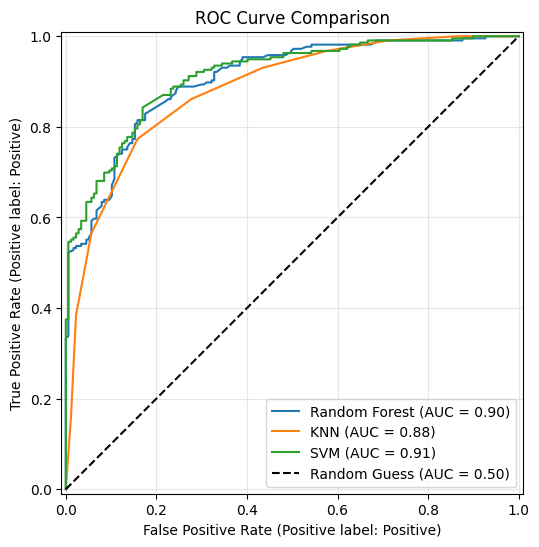

In [43]:
from sklearn.metrics import RocCurveDisplay

models = {
    'Random Forest': rf_model,
    'KNN': knn_model,
    'SVM': svm_model
}

fig, ax = plt.subplots(figsize=(10, 6))

# Loop using the string label 'Positive'
for name, model in models.items():
    RocCurveDisplay.from_estimator(
        model,
        X_test,
        y_test,
        ax=ax,
        name=name,
        pos_label='Positive'
    )

ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess (AUC = 0.50)')
ax.set_title('ROC Curve Comparison')
ax.grid(alpha=0.3)
plt.legend()
plt.show()

## **Recall Curve visualization**

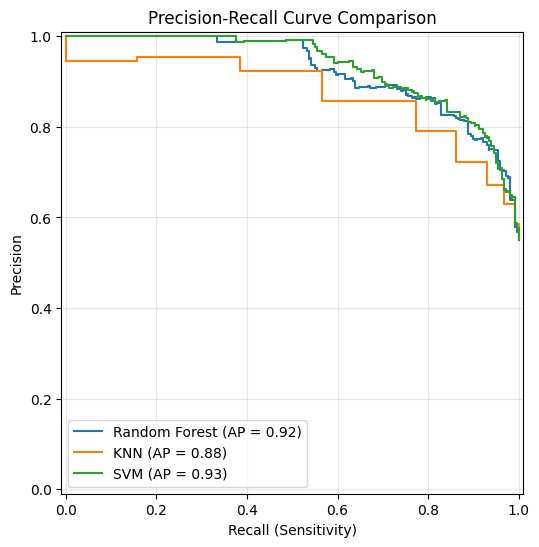

In [44]:
from sklearn.metrics import PrecisionRecallDisplay

# setup plot
fig, ax = plt.subplots(figsize=(10, 6))

# loop and plot
for name, model in models.items():
    PrecisionRecallDisplay.from_estimator(
        model,
        X_test,
        y_test,
        ax=ax,
        name=name,
        pos_label='Positive' # focus on positive calss
    )

ax.set_title('Precision-Recall Curve Comparison')
ax.set_xlabel('Recall (Sensitivity)')
ax.set_ylabel('Precision')
ax.grid(alpha=0.3)
plt.legend(loc='best')
plt.show()

## **Model Accuracy Comparision**

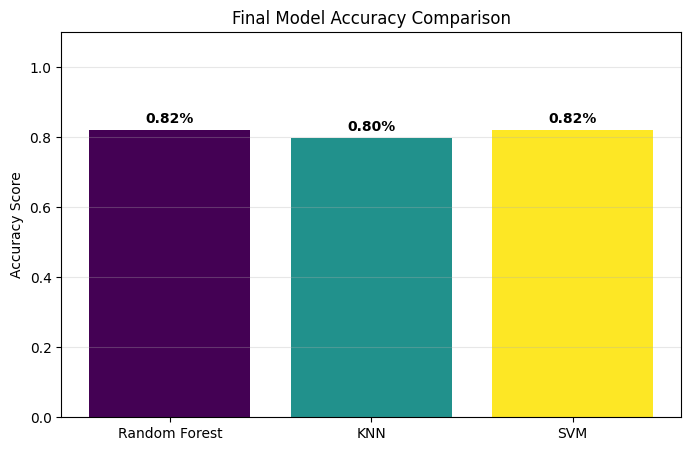

In [45]:
models = ['Random Forest', 'KNN', 'SVM']
scores = [rf_acc, knn_acc, svm_acc]

#plott
plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['#440154', '#21918c', '#fde725']) # Viridis colors

plt.bar_label(bars, fmt='%.2f%%', padding=3, fontweight='bold') # Adds percentages automatically
plt.title('Final Model Accuracy Comparison')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy Score')
plt.grid(axis='y', alpha=0.3)

plt.show()

In [46]:
# TEst PREDICTION ---

def predict_student_sentiment(new_feedback):
    cleaned_text = clean_text_function(new_feedback)
    vectorized_text = tfidf_binary.transform([cleaned_text]).toarray()

    if vectorized_text.sum() == 0:
        return "Unknown (Words is not in training data)"

    # USing SVM as it got higher overall accuracy
    prediction = svm_model.predict(vectorized_text)[0]

    return prediction

# Interactive Loop
print("--- STUDENT FEEDBACK SENTIMENT ANALYSIS ---")
print("Type 'exit' to quit.")

while True:
    user_input = input("\nEnter Student Feedback: ")
    if user_input.lower() == 'exit':
        break

    result = predict_student_sentiment(user_input)
    print(f"Analysis Result:  {result} ")

--- STUDENT FEEDBACK SENTIMENT ANALYSIS ---
Type 'exit' to quit.

Enter Student Feedback: exit
